In [2]:
import hssm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob

# Load Data

In [41]:
# NOT RUN: data manipulation
# 1) concatenate data across datasets
# 2) add in a group variable
# 3) exclude rows according to the exclusion flags
# 4) rename variables: `subject_id` --> `participant_id`, `resp_rt` --> `rt`, `resp_value` --> `response`
# 5) recode response: left = 1, right = -1, none = 0; remove rows with none
# 6) store into a new file

# need to make sure the directory containing data is downloaded to local
# otherwise will encounter the error "resource deadlock avoided"

# data_UIC_CAR = pd.read_csv("../data_all_cleaned/CAR_UIC_flanker_cleaned.csv")
# data_USC_CAR = pd.read_csv("../data_all_cleaned/CAR_USC_flanker_cleaned.csv")
# data_UIC_PARC = pd.read_csv("../data_all_cleaned/PARC_UIC_flanker_cleaned.csv")
# data_USC_PARC = pd.read_csv("../data_all_cleaned/PARC_USC_flanker_cleaned.csv")

# data_UIC_CAR["school"] = "UIC"
# data_USC_CAR["school"] = "USC"
# data_UIC_PARC["school"] = "UIC"
# data_USC_PARC["school"] = "USC"

# data_CAR = pd.concat((data_UIC_CAR, data_USC_CAR), axis=0)
# MDD = pd.read_csv("../MDD_all.csv")
# MDD = MDD.rename(columns={"ID": "subject_id", "MDDnew": "group"})
# MDD.loc[MDD.group == 0, 'group'] = "HC"
# MDD.loc[MDD.group == 1, 'group'] = "rMDD"
# data_CAR = pd.merge(data_CAR, MDD, on = "subject_id")

# data_PARC = pd.concat((data_UIC_PARC, data_USC_PARC), axis=0)
# data_PARC["group"] = "SI"
# data = pd.concat((data_CAR, data_PARC), axis=0)

# data = data.rename(columns={"subject_id": "participant_id",
#                            "resp_rt": "rt",
#                            "trial_congruent_fac": "trial_type",
#                            "resp_value": "response"})

# # recode response: left = 1, right = -1, none = 0
# data['response'] = data['response'].map({'left': 1, 'right': -1, 'none': 0}).astype(int)
# # remove the rows that have a 'none' response
# data = data.loc[data.response != 0, :]

# # exclude rows according to the exclusion flags
# data_clean = data.loc[(data.exclude_trial == 0) & (data.exclude_part == 0), :]

# data.to_csv("../data_all_cleaned/flanker_all.csv", index=False)
# data_clean.to_csv("../data_all_cleaned/flanker_all_hssm.csv", index=False)

/var/folders/n6/fp80fdw91fj2k_2bq9yqc8zh0000gn/T/ipykernel_89776/1263648832.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'HC' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  MDD.loc[MDD.group == 0, 'group'] = "HC"


In [3]:
data = pd.read_csv('../data_all_cleaned/flanker_all.csv')

In [4]:
data.head()

,participant_id,trial_type,resp_corr,rt,response,log_rt,mean_log_rt,sd_log_rt,exclude_trial,exclude_part,school,group
0,1903,congruent,1,0.841311,1,-0.172794,-0.068957,0.162905,0,0,UIC,rMDD
1,1903,incongruent,1,1.105856,-1,0.100620,0.010727,0.142670,0,0,UIC,rMDD
2,1903,incongruent,1,1.151826,1,0.141349,0.010727,0.142670,0,0,UIC,rMDD
3,1903,congruent,1,0.710728,-1,-0.341465,-0.068957,0.162905,0,0,UIC,rMDD
4,1903,incongruent,1,0.956795,1,-0.044167,0.010727,0.142670,0,0,UIC,rMDD


In [5]:
print('There are ' + str(len(data.participant_id.unique())) + ' participants.')
print(str(len(data.groupby(['group'])['participant_id'].unique()['HC'])) + ' HCs.')
print(str(len(data.groupby(['group'])['participant_id'].unique()['rMDD'])) + ' people with rMDD.')
print(str(len(data.groupby(['group'])['participant_id'].unique()['SI'])) + ' people with SI.')

There are 131 participants.
51 HCs.
51 people with rMDD.
29 people with SI.


# Modeling

## Model Setup

### M3: Interaction Between Group and Trial Type

In [49]:
param_v_int = {"name": "v",
           "formula": "v ~ 1 + group*trial_type + (1|participant_id)"
           }
param_a_int = {"name": "a",
               "formula": "a ~ 1 + group*trial_type + (1|participant_id)"
               }
param_t_int = {"name": "t",
               "formula": "t ~ 1 + group*trial_type + (1|participant_id)"
               }
m_int = hssm.HSSM(data=data,
                  model="ddm",
                  include=[param_v_int, param_a_int, param_t_int],
                  hierarchical=True,
                  prior_settings="safe")

Model initialized successfully.


In [50]:
m_int

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 6287

Parameters:

v:
    Formula: v ~ 1 + group*trial_type + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_group ~ Normal(mu: 0.0, sigma: 0.25)
        v_trial_type ~ Normal(mu: 0.0, sigma: 0.25)
        v_group:trial_type ~ Normal(mu: 0.0, sigma: 0.25)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + group*trial_type + (1|participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_group ~ Normal(mu: 0.0, sigma: 0.25)
        a_trial_type ~ Normal(mu: 0.0, sigma: 0.25)
        a_group:trial_type ~ Normal(mu: 0.0, sigma: 0.25)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|

### M1: Trial Type Only

In [6]:
param_v_trial = {"name": "v",
           "formula": "v ~ 1 + trial_type + (1|participant_id)"
           }
param_a_trial = {"name": "a",
               "formula": "a ~ 1 + trial_type + (1|participant_id)"
               }
param_t_trial = {"name": "t",
               "formula": "t ~ 1 + trial_type + (1|participant_id)"
               }
m_trial = hssm.HSSM(data=data,
                  model="ddm",
                  include=[param_v_trial, param_a_trial, param_t_trial],
                  hierarchical=True,
                  prior_settings="safe")

Model initialized successfully.


In [7]:
m_trial

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 6287

Parameters:

v:
    Formula: v ~ 1 + trial_type + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_trial_type ~ Normal(mu: 0.0, sigma: 0.25)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + trial_type + (1|participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_trial_type ~ Normal(mu: 0.0, sigma: 0.25)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
   

### M2: Group Only

In [8]:
param_v_group = {"name": "v",
           "formula": "v ~ 1 + group + (1|participant_id)"
           }
param_a_group = {"name": "a",
               "formula": "a ~ 1 + group + (1|participant_id)"
               }
param_t_group = {"name": "t",
               "formula": "t ~ 1 + group + (1|participant_id)"
               }
m_group = hssm.HSSM(data=data,
                  model="ddm",
                  include=[param_v_group, param_a_group, param_t_group],
                  hierarchical=True,
                  prior_settings="safe")

Model initialized successfully.


In [9]:
m_group

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 6287

Parameters:

v:
    Formula: v ~ 1 + group + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_group ~ Normal(mu: 0.0, sigma: 0.25)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + group + (1|participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_group ~ Normal(mu: 0.0, sigma: 0.25)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1 + gr

## Running the Models

In [125]:
"""
4 chains, (`draws`+`tune`) iterations, burn-in of `tune`.
Sampler: NUTS
"""

chains = 4
draws = 10000
burn = 5000

m_int_trace = m_int.sample(draws=draws, chains=chains, tune=burn, cores=4)
m_trial_trace = m_trial.sample(draws=draws, chains=chains, tune=burn, cores=4)
m_group_trace = m_group.sample(draws=draws, chains=chains, tune=burn, cores=4)

Using default initvals. 



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_Intercept, v_group, v_trial_type, v_group:trial_type, v_1|participant_id_sigma, v_1|participant_id_offset, a_Intercept, a_group, a_trial_type, a_group:trial_type, a_1|participant_id_sigma, a_1|participant_id_offset, z_Intercept, z_1|participant_id_sigma, z_1|participant_id_offset, t_Intercept, t_1|participant_id_sigma, t_1|participant_id_offset]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 5667 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|████████████████████████████████████| 40000/40000 [01:03<00:00, 629.07it/s]


In [ ]:
# save inference data
m_int_trace.to_netcdf('../models_hssm/m_int_15000.nc')
m_trial_trace.to_netcdf('../models_hssm/m_trial_15000.nc')
m_group_trace.to_netcdf('../models_hssm/m_group_15000.nc')

## Model Comparison

In [140]:
compare_data = az.compare(
    {
        "M1 (trial type only)": m_trial.traces,
        "M2 (group only)": m_group.traces,
        "M3 (interaction)": m_int.traces
    }, ic="waic"
)

compare_data

/opt/anaconda3/envs/env/lib/python3.11/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.11/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.11/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
M1 (trial type only),0,286.306166,550.818667,0.000000,0.603947,92.587772,0.00000,True,log
M3 (interaction),1,231.058294,641.589282,55.247872,0.256825,95.405082,29.48683,True,log
M2 (group only),2,-364.802598,520.289805,651.108764,0.139228,80.396084,74.26282,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

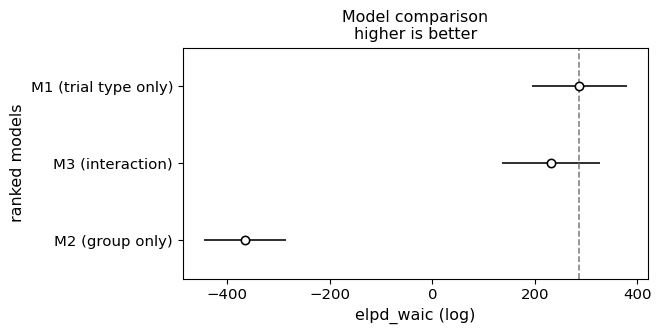

In [141]:
az.plot_compare(compare_data)

## Convergence Diagnostics

### Trace Plots

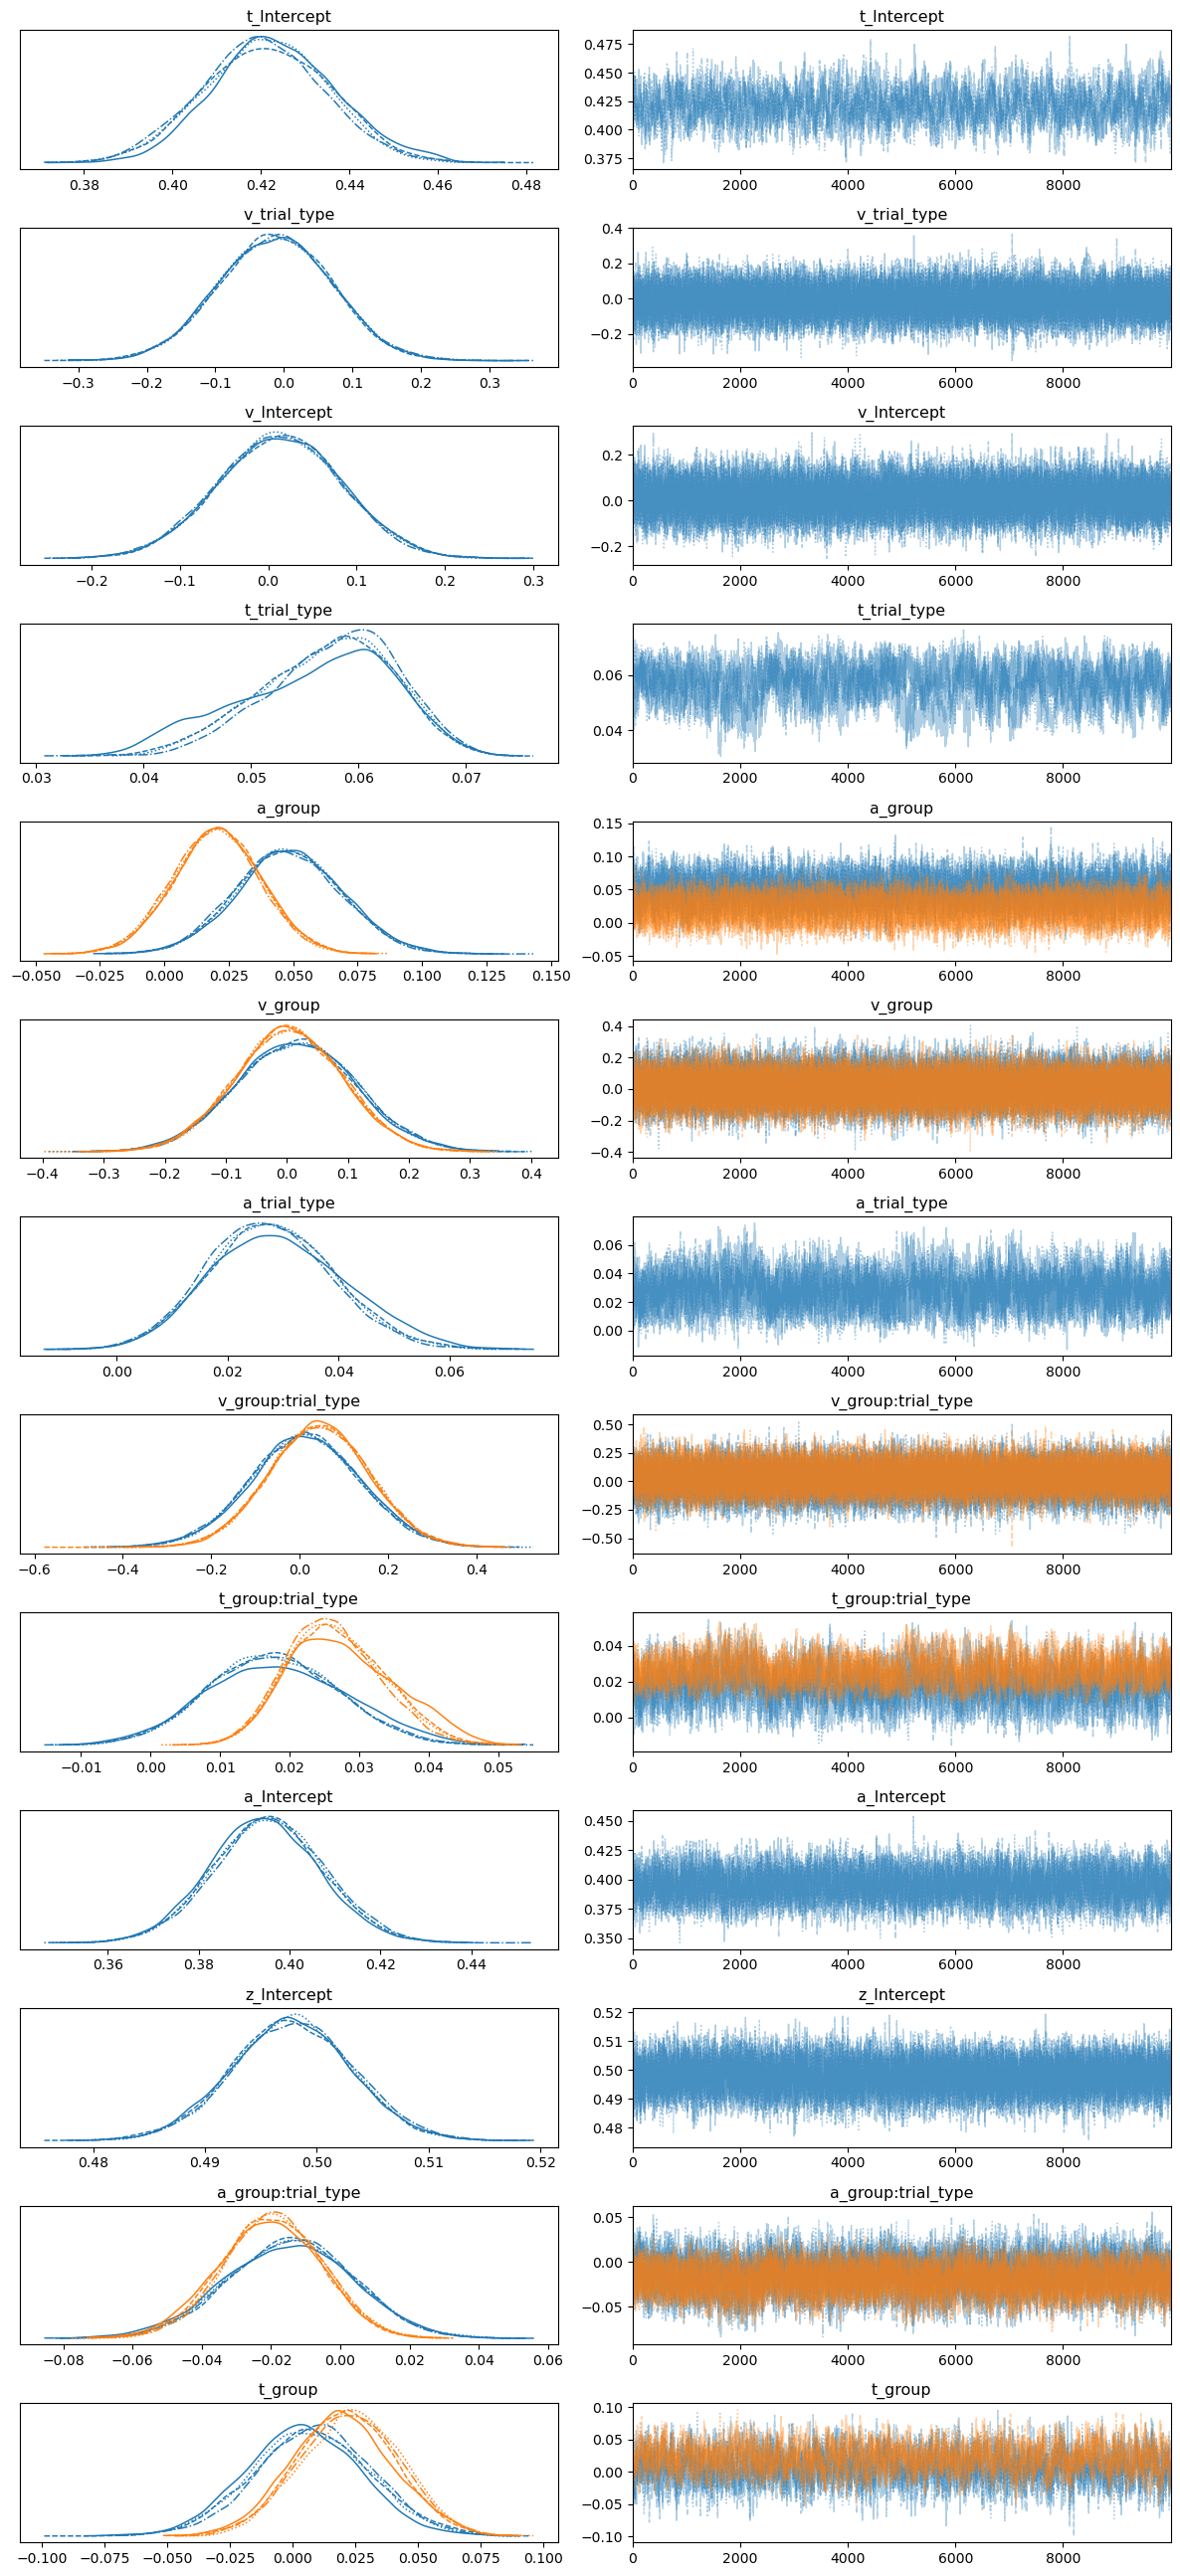

In [313]:
# Specify model to examine
trace = m_int_trace
# Specify DDM parameters to examine
params = ["^(v|a|t|z)_[a-zA-Z]+"]
az.plot_trace(trace, var_names=params, filter_vars="regex")
plt.tight_layout()

### Rank Histograms

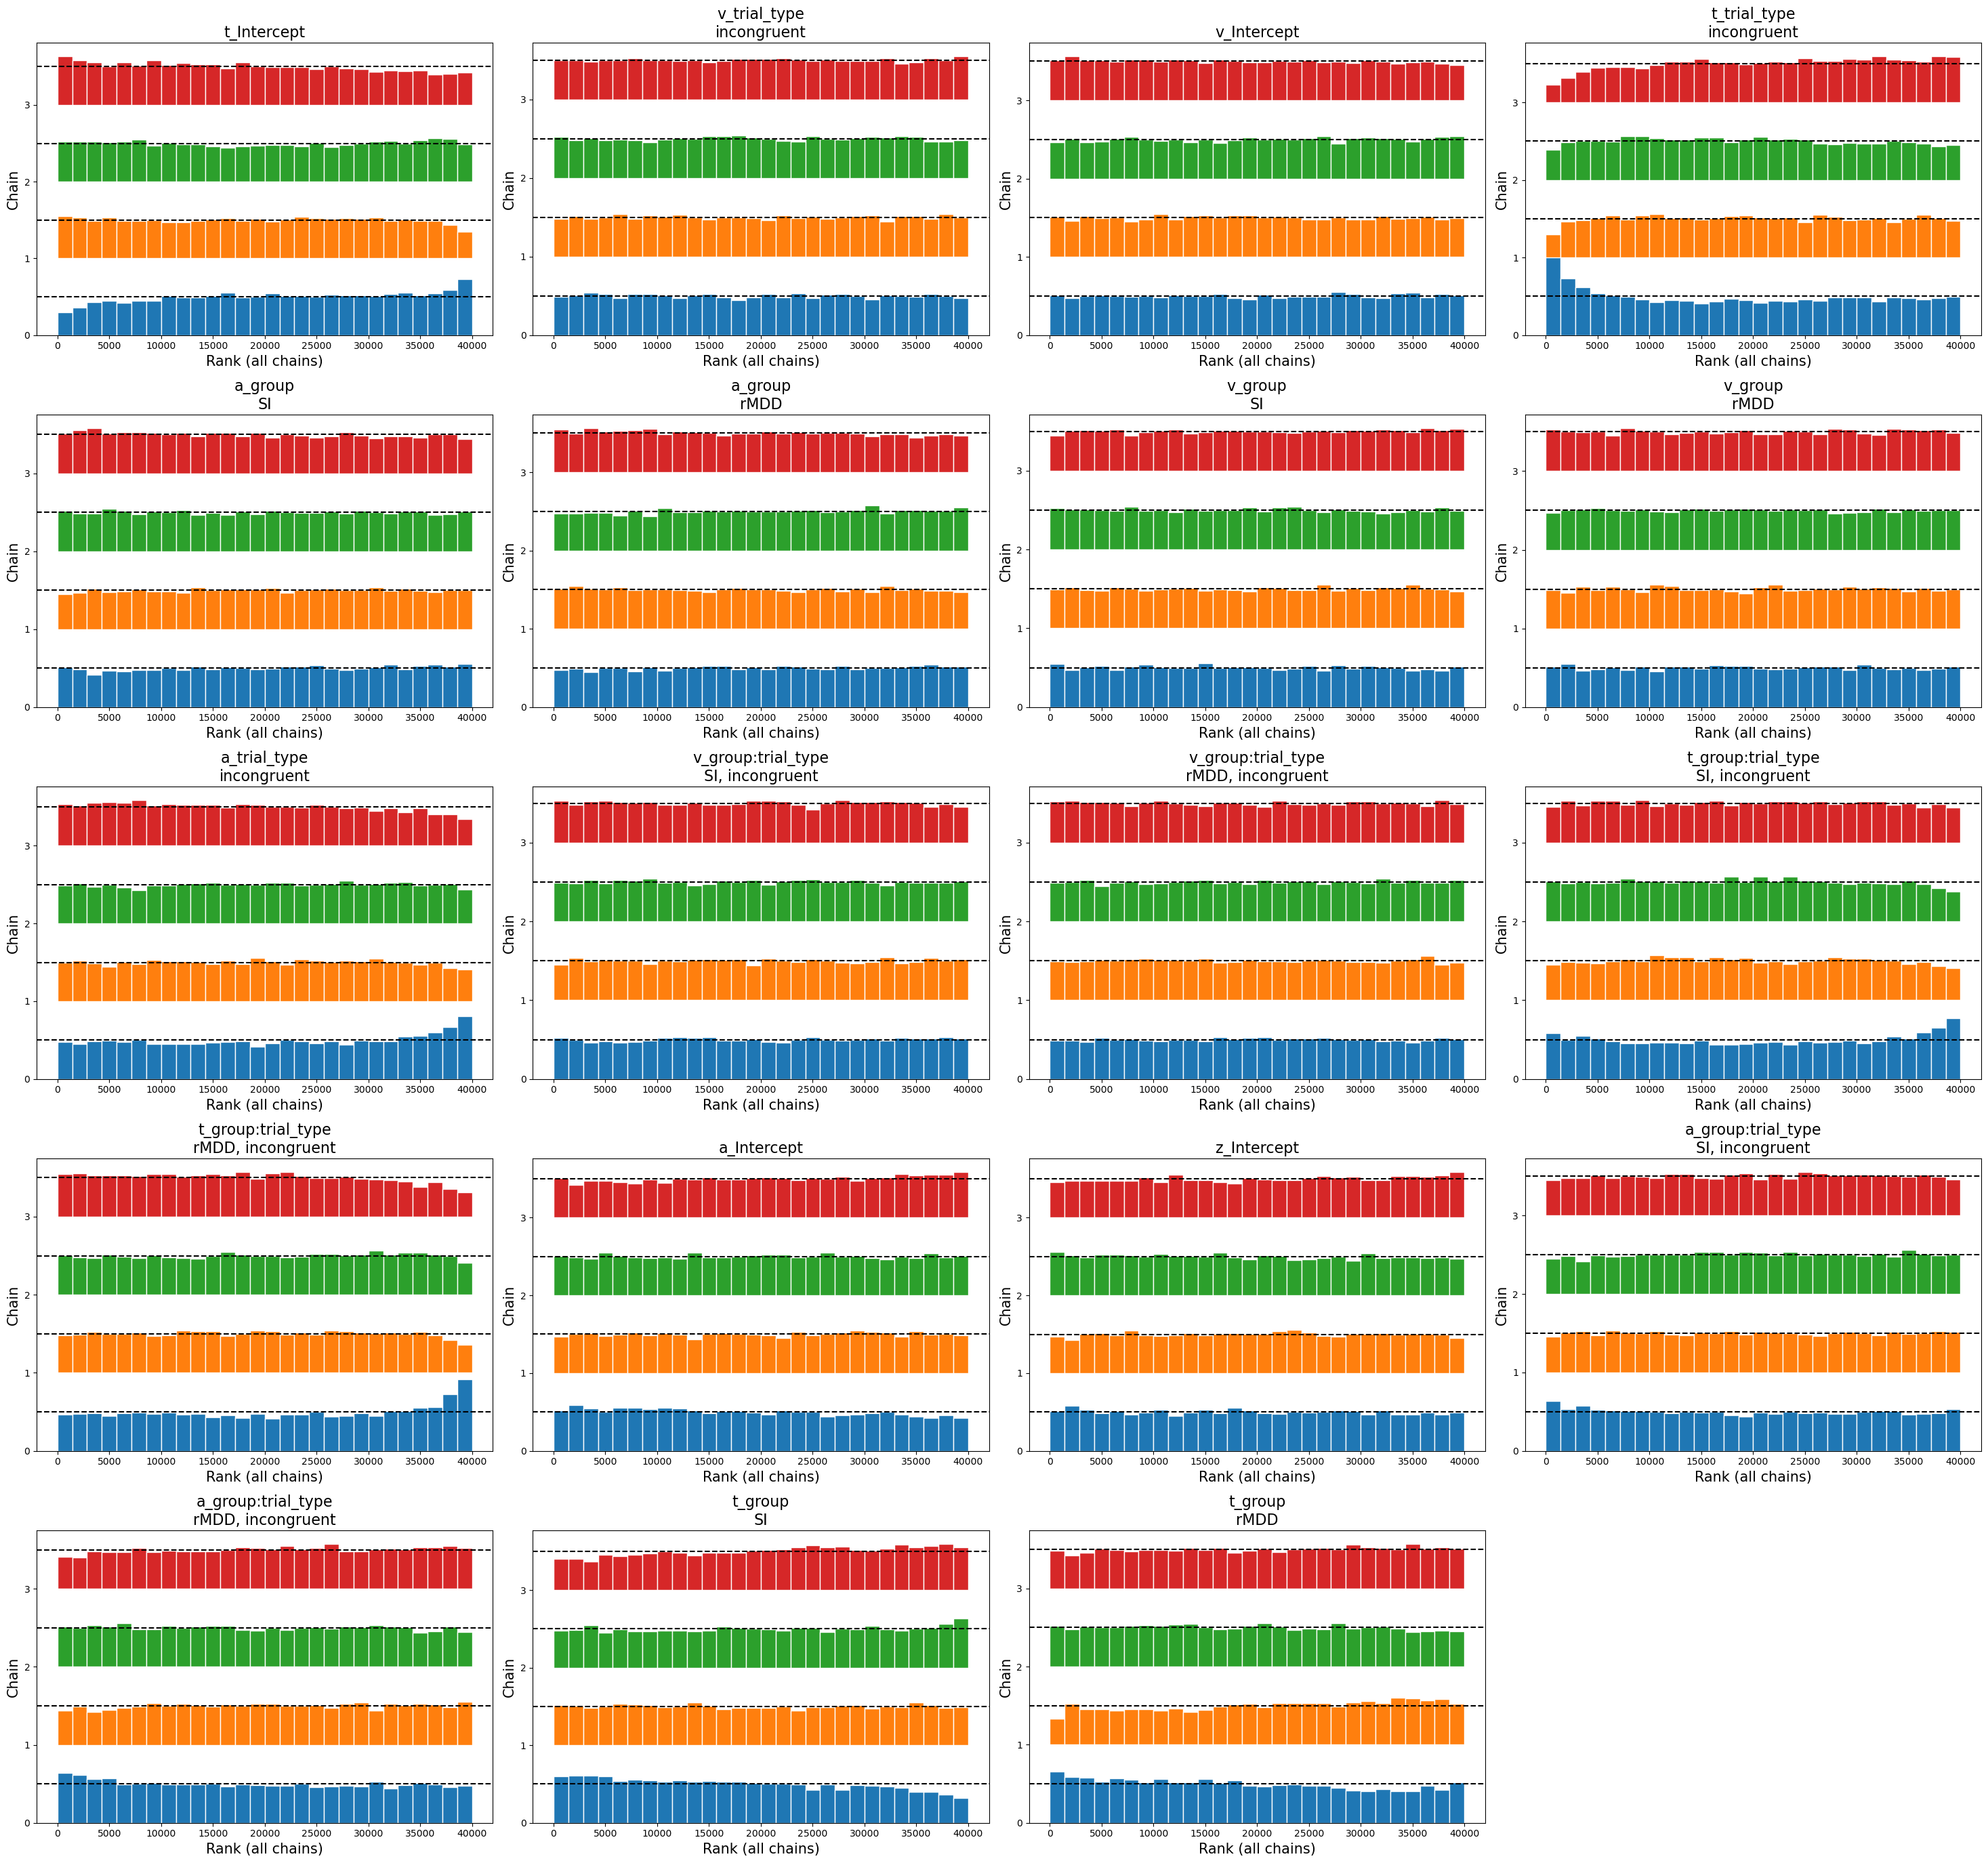

In [333]:
az.plot_rank(trace, var_names=params, filter_vars="regex")
plt.tight_layout()

In [183]:
az.summary(trace, var_names=params, filter_vars="regex", hdi_prob=.8)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_Intercept,0.422,0.014,0.402,0.439,0.000,0.000,1107.0,2376.0,1.01
v_trial_type[incongruent],-0.013,0.082,-0.115,0.095,0.000,0.000,27406.0,27732.0,1.00
v_Intercept,0.013,0.070,-0.075,0.104,0.000,0.000,25554.0,28692.0,1.00
t_trial_type[incongruent],0.057,0.006,0.049,0.066,0.000,0.000,188.0,238.0,1.02
a_group[SI],0.048,0.020,0.023,0.075,0.000,0.000,5587.0,14363.0,1.00
a_group[rMDD],0.020,0.017,-0.001,0.043,0.000,0.000,4581.0,11300.0,1.00
v_group[SI],0.016,0.098,-0.112,0.137,0.001,0.000,28655.0,29134.0,1.00
v_group[rMDD],0.003,0.088,-0.111,0.115,0.001,0.000,29649.0,28577.0,1.00
a_trial_type[incongruent],0.028,0.012,0.013,0.043,0.001,0.000,393.0,860.0,1.01
"v_group:trial_type[SI, incongruent]",0.014,0.124,-0.145,0.174,0.001,0.001,26834.0,27232.0,1.00


## Examine Group Differences

In [303]:
# Get posterior draws for each of the 6 combinations

m_int_df = m_int_trace.to_dataframe(var_names=params, filter_vars="regex", include_coords=True)
m_int_df.columns = ['_'.join(x) if len(x) == 2 else x for x in m_int_df.columns]

v_HC_incongruent = m_int_df['v_Intercept'] + m_int_df['v_trial_type[0]_incongruent']
v_rMDD_congruent = m_int_df['v_Intercept'] + m_int_df['v_group[1]_rMDD']
v_rMDD_incongruent = m_int_df['v_Intercept'] + m_int_df['v_trial_type[0]_incongruent'] + \
m_int_df['v_group[1]_rMDD'] + m_int_df['v_group:trial_type[1]_rMDD, incongruent']
v_SI_congruent = m_int_df['v_Intercept'] + m_int_df['v_group[0]_SI']
v_SI_incongruent = m_int_df['v_Intercept'] + m_int_df['v_trial_type[0]_incongruent'] + \
m_int_df['v_group[0]_SI'] + m_int_df['v_group:trial_type[0]_SI, incongruent']

a_HC_incongruent = m_int_df['a_Intercept'] + m_int_df['a_trial_type[0]_incongruent']
a_rMDD_congruent = m_int_df['a_Intercept'] + m_int_df['a_group[1]_rMDD']
a_rMDD_incongruent = m_int_df['a_Intercept'] + m_int_df['a_trial_type[0]_incongruent']  + \
m_int_df['a_group[1]_rMDD'] + m_int_df['a_group:trial_type[1]_rMDD, incongruent']
a_SI_congruent = m_int_df['a_Intercept'] + m_int_df['a_group[0]_SI']
a_SI_incongruent = m_int_df['a_Intercept'] + m_int_df['a_trial_type[0]_incongruent'] + \
m_int_df['a_group[0]_SI'] + m_int_df['a_group:trial_type[0]_SI, incongruent']

t_HC_incongruent = m_int_df['t_Intercept'] + m_int_df['t_trial_type[0]_incongruent']
t_rMDD_congruent = m_int_df['t_Intercept'] + m_int_df['t_group[1]_rMDD']
t_rMDD_incongruent = m_int_df['t_Intercept'] + m_int_df['t_trial_type[0]_incongruent'] + \
m_int_df['t_group[1]_rMDD'] + m_int_df['t_group:trial_type[1]_rMDD, incongruent']
t_SI_congruent = m_int_df['t_Intercept'] + m_int_df['t_group[0]_SI']
t_SI_incongruent = m_int_df['t_Intercept'] + m_int_df['t_trial_type[0]_incongruent'] + \
m_int_df['t_group[0]_SI'] + m_int_df['t_group:trial_type[0]_SI, incongruent']

posterior_draws_dict = {'v_HC_congruent': m_int_df['v_Intercept'],
             'v_HC_incongruent': v_HC_incongruent,
             'v_rMDD_congruent': v_rMDD_congruent,
             'v_rMDD_incongruent': v_rMDD_incongruent,
             'v_SI_congruent': v_SI_congruent,
             'v_SI_incongruent': v_SI_incongruent,
             'a_HC_congruent': m_int_df['a_Intercept'],
             'a_HC_incongruent': a_HC_incongruent,
             'a_rMDD_congruent': a_rMDD_congruent,
             'a_rMDD_incongruent': a_rMDD_incongruent,
             'a_SI_congruent': a_SI_congruent,
             'a_SI_incongruent': a_SI_incongruent,
             't_HC_congruent': m_int_df['t_Intercept'],
             't_HC_incongruent': t_HC_incongruent,
             't_rMDD_congruent': t_rMDD_congruent,
             't_rMDD_incongruent': t_rMDD_incongruent,
             't_SI_congruent': t_SI_congruent,
             't_SI_incongruent': t_SI_incongruent}
posterior_draws = pd.DataFrame(posterior_draws_dict)
posterior_draws_inf = az.convert_to_dataset(posterior_draws_dict)

In [324]:
az.summary(posterior_draws_dict)

arviz - WARNING - Shape validation failed: input_shape: (1, 40000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_HC_congruent,0.013,0.070,-0.117,0.145,0.0,0.0,25416.0,28634.0,NaN
v_HC_incongruent,0.000,0.069,-0.132,0.129,0.0,0.0,36583.0,31699.0,NaN
v_rMDD_congruent,0.016,0.071,-0.115,0.152,0.0,0.0,40185.0,31072.0,NaN
v_rMDD_incongruent,0.047,0.071,-0.085,0.182,0.0,0.0,43064.0,32931.0,NaN
v_SI_congruent,0.029,0.085,-0.131,0.189,0.0,0.0,38550.0,31161.0,NaN
v_SI_incongruent,0.030,0.086,-0.135,0.189,0.0,0.0,43946.0,32956.0,NaN
a_HC_congruent,0.395,0.012,0.372,0.418,0.0,0.0,3352.0,9305.0,NaN
a_HC_incongruent,0.423,0.013,0.399,0.448,0.0,0.0,956.0,5138.0,NaN
a_rMDD_congruent,0.415,0.012,0.393,0.439,0.0,0.0,6169.0,15664.0,NaN
a_rMDD_incongruent,0.424,0.012,0.401,0.446,0.0,0.0,8842.0,17493.0,NaN


In [317]:
print('80% HDI for v_HC_congruent: ' + str(az.hdi(np.array(m_int_df['v_Intercept']), hdi_prob=.8)))
print('80% HDI for v_rMDD_congruent: ' + str(az.hdi(np.array(v_rMDD_congruent), hdi_prob=.8)))
print('80% HDI for v_SI_congruent: ' + str(az.hdi(np.array(v_SI_congruent), hdi_prob=.8)))
print(' ')

print('80% HDI for v_HC_incongruent: ' + str(az.hdi(np.array(v_HC_incongruent), hdi_prob=.8)))
print('80% HDI for v_rMDD_incongruent: ' + str(az.hdi(np.array(v_rMDD_incongruent), hdi_prob=.8)))
print('80% HDI for v_SI_incongruent: ' + str(az.hdi(np.array(v_SI_incongruent), hdi_prob=.8)))
print(' ')

print('80% HDI for a_HC_congruent: ' + str(az.hdi(np.array(m_int_df['a_Intercept']), hdi_prob=.8)))
print('80% HDI for a_rMDD_congruent: ' + str(az.hdi(np.array(a_rMDD_congruent), hdi_prob=.8)))
print('80% HDI for a_SI_congruent: ' + str(az.hdi(np.array(a_SI_congruent), hdi_prob=.8)))
print(' ')

print('80% HDI for a_HC_incongruent: ' + str(az.hdi(np.array(a_HC_incongruent), hdi_prob=.8)))
print('80% HDI for a_rMDD_incongruent: ' + str(az.hdi(np.array(a_rMDD_incongruent), hdi_prob=.8)))
print('80% HDI for a_SI_incongruent: ' + str(az.hdi(np.array(a_SI_incongruent), hdi_prob=.8)))
print(' ')

print('80% HDI for t_HC_congruent: ' + str(az.hdi(np.array(m_int_df['t_Intercept']), hdi_prob=.8)))
print('80% HDI for t_rMDD_congruent: ' + str(az.hdi(np.array(t_rMDD_congruent), hdi_prob=.8)))
print('80% HDI for t_SI_congruent: ' + str(az.hdi(np.array(t_SI_congruent), hdi_prob=.8)))
print(' ')

print('80% HDI for t_HC_incongruent: ' + str(az.hdi(np.array(t_HC_incongruent), hdi_prob=.8)))
print('80% HDI for t_rMDD_incongruent: ' + str(az.hdi(np.array(t_rMDD_incongruent), hdi_prob=.8)))
print('80% HDI for t_SI_incongruent: ' + str(az.hdi(np.array(t_SI_incongruent), hdi_prob=.8)))

80% HDI for v_HC_congruent: [-0.07503352  0.10425022]
80% HDI for v_rMDD_congruent: [-0.0736117   0.10876735]
80% HDI for v_SI_congruent: [-0.077706    0.14002372]
 
80% HDI for v_HC_incongruent: [-0.08947484  0.08727968]
80% HDI for v_rMDD_incongruent: [-0.04604258  0.13444153]
80% HDI for v_SI_incongruent: [-0.07825547  0.14129115]
 
80% HDI for a_HC_congruent: [0.37938185 0.41033081]
80% HDI for a_rMDD_congruent: [0.39982553 0.43060144]
80% HDI for a_SI_congruent: [0.42304623 0.46524668]
 
80% HDI for a_HC_incongruent: [0.40625379 0.43944077]
80% HDI for a_rMDD_incongruent: [0.40807611 0.43918182]
80% HDI for a_SI_incongruent: [0.43527983 0.47854536]
 
80% HDI for t_HC_congruent: [0.4024148  0.43875524]
80% HDI for t_rMDD_congruent: [0.4255328  0.46234992]
80% HDI for t_SI_congruent: [0.403496   0.45203858]
 
80% HDI for t_HC_incongruent: [0.45902983 0.49595962]
80% HDI for t_rMDD_incongruent: [0.50845288 0.54535163]
80% HDI for t_SI_incongruent: [0.47888041 0.52774266]


In [328]:
# Get posterior draws of group differences
groups = ['HC', 'rMDD', 'SI']
ddm_params = ['v', 'a', 't']
trials = ['congruent', 'incongruent']

for g in groups:
    groups_other = [group for group in groups if group != g]
    for p in ddm_params:
        for t in trials:
            for g_other in groups_other:
                hdi = az.hdi(np.array(posterior_draws[p+'_'+g+'_'+t] - posterior_draws[p+'_'+g_other+'_'+t]))
                if (0 > hdi[1]) | (0 < hdi[0]):
                    print('There is a significant difference between '+g+' and '+g_other+' in '+p+'_'+t)
                    print(hdi)

There is a significant difference between HC and SI in a_congruent
[-0.08674484 -0.01019294]
There is a significant difference between HC and rMDD in t_incongruent
[-0.08602999 -0.01015949]
There is a significant difference between rMDD and HC in t_incongruent
[0.01015949 0.08602999]
There is a significant difference between SI and HC in a_congruent
[0.01019294 0.08674484]


In [330]:
sig_diff = {'HC - SI, a_congruent': posterior_draws['a_HC_congruent'] - posterior_draws['a_SI_congruent'],
           'HC - rMDD, t_incongruent': posterior_draws['t_HC_incongruent'] - posterior_draws['t_rMDD_incongruent']}
az.summary(sig_diff, hdi_prob=.8)

arviz - WARNING - Shape validation failed: input_shape: (1, 40000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"HC - SI, a_congruent",-0.048,0.02,-0.075,-0.023,0.000,0.0,5536.0,14285.0,NaN
"HC - rMDD, t_incongruent",-0.049,0.02,-0.075,-0.024,0.001,0.0,969.0,2162.0,NaN


<Axes: ylabel='Density'>

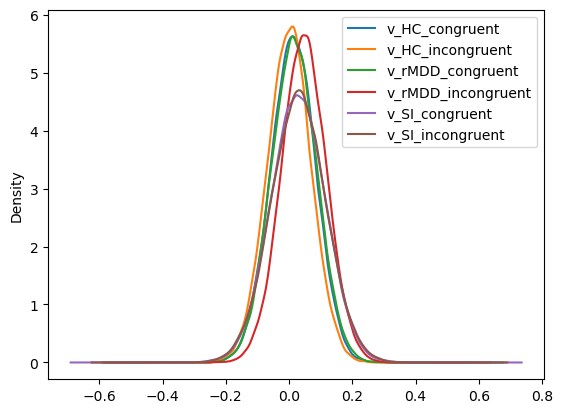

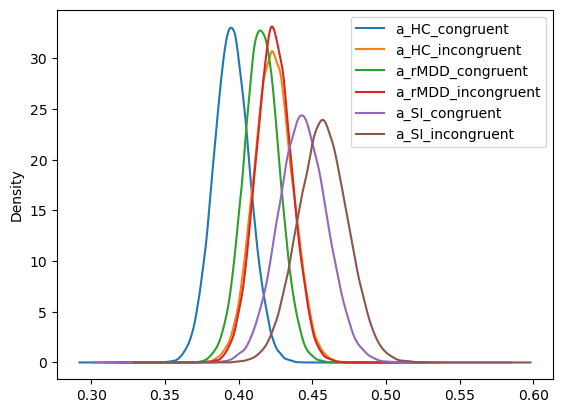

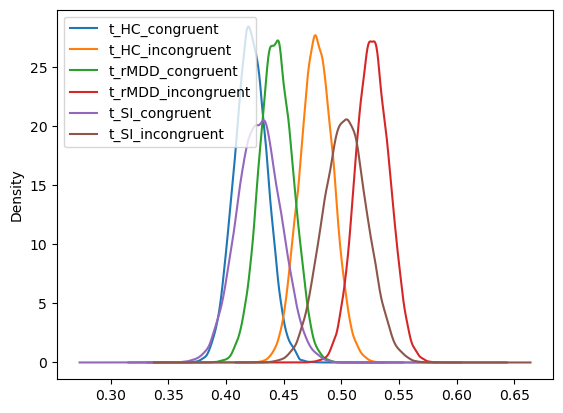

In [302]:
# Plot posterior draws of the six combinations
posterior_draws.loc[:, [var for var in posterior_draws.columns if 'v_' in var]].plot.kde()
posterior_draws.loc[:, [var for var in posterior_draws.columns if 'a_' in var]].plot.kde()
posterior_draws.loc[:, [var for var in posterior_draws.columns if 't_' in var]].plot.kde()

In [331]:
# get samples from the posterior predictive distributions
m_int_postdraws = m_int.sample_posterior_predictive(idata=m_int_trace, data=data, draws=1000)

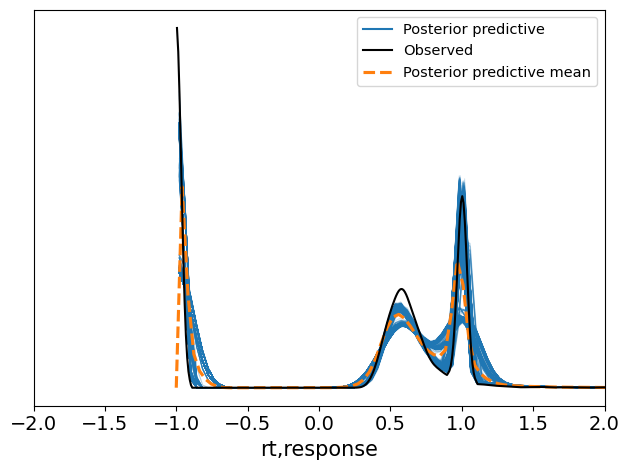

In [332]:
# az.plot_posterior(m_trial_trace, var_names=params, filter_vars="regex", hdi_prob=.8)
az.plot_ppc(m_int_trace)
plt.xlim(-2, 2)
plt.tight_layout()

<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

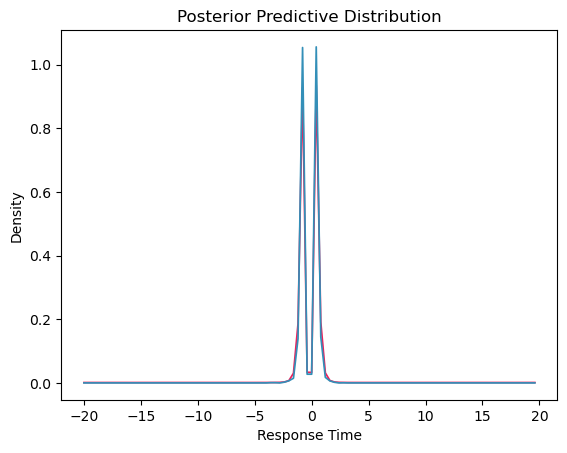

In [165]:
m_trial.plot_posterior_predictive(n_samples=1000)